In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import random
import warnings
from datetime import datetime

import gdown
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_ms_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps_v2,
                                generate_enriched_gp_info_plots)
import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset = "CosMx mousebrain"
species = "mouse"
spatial_key = "spatial"
n_neighbors = 10

### Model ###
# AnnData Keys
counts_key = "counts"
adj_key = "spatial_connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Architecture
conv_layer_encoder = "gcnconv" # change to "gatv2conv" if enough compute and memory
active_gp_thresh_ratio = 0.01

# Trainer
n_epochs = 400
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_l1_masked = 0. # prior GP  regularization
lambda_l1_addon = 30. # de novo GP regularization
edge_batch_size = 4096 # increase if more memory available or decrease to save memory
n_sampled_neighbors = 4
use_cuda_if_available = True

### Analysis ###
cell_type_key = "Main_molecular_cell_type"
latent_leiden_resolution = 0.4
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "batch"
spot_size = 0.2
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

In [4]:
warnings.filterwarnings("ignore")

In [5]:
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [6]:
ga_data_folder_path = "/home/dbj/HERGAST/data/gene_annotations"
gp_data_folder_path = "/home/dbj/HERGAST/data/gene_programs"
so_data_folder_path = "/home/dbj/HERGAST/data/spatial_omics"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
collectri_tf_network_file_path = f"{gp_data_folder_path}/collectri_tf_network_{species}.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
artifacts_folder_path = f"./artifacts"
model_folder_path = f"{artifacts_folder_path}/single_sample/{current_timestamp}/model"
figure_folder_path = f"{artifacts_folder_path}/single_sample/{current_timestamp}/figures"

In [7]:
os.makedirs(model_folder_path, exist_ok=True)
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(so_data_folder_path, exist_ok=True)

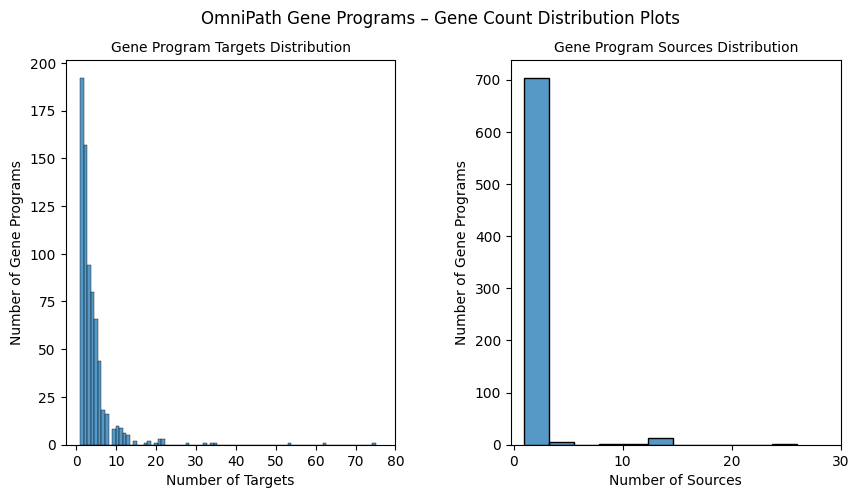

In [8]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True,
    gp_gene_count_distributions_save_path=f"{figure_folder_path}" \
                                           "/omnipath_gp_gene_count_distributions.svg")

In [9]:
omnipath_gp_names = list(omnipath_gp_dict.keys())
random.shuffle(omnipath_gp_names)
omnipath_gp_name = omnipath_gp_names[0]
print(f"{omnipath_gp_name}: {omnipath_gp_dict[omnipath_gp_name]}")

OBP2A_ligand_receptor_GP: {'sources': ['Obp2b', 'Lcn4', 'Obp2a'], 'targets': ['Or1g1'], 'sources_categories': ['ligand', 'ligand', 'ligand'], 'targets_categories': ['receptor']}


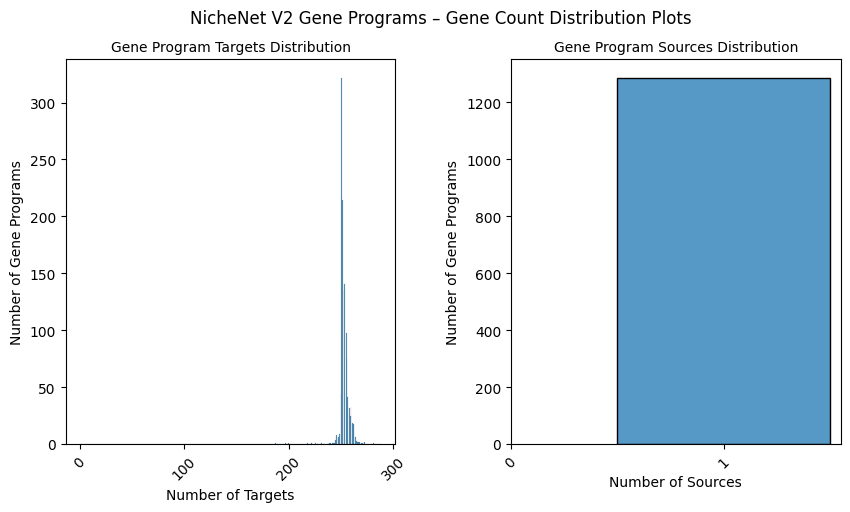

In [10]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    keep_target_genes_ratio=1.,
    max_n_target_genes_per_gp=250,
    load_from_disk=True,
    save_to_disk=True,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

In [11]:
nichenet_gp_names = list(nichenet_gp_dict.keys())
random.shuffle(nichenet_gp_names)
nichenet_gp_name = nichenet_gp_names[0]

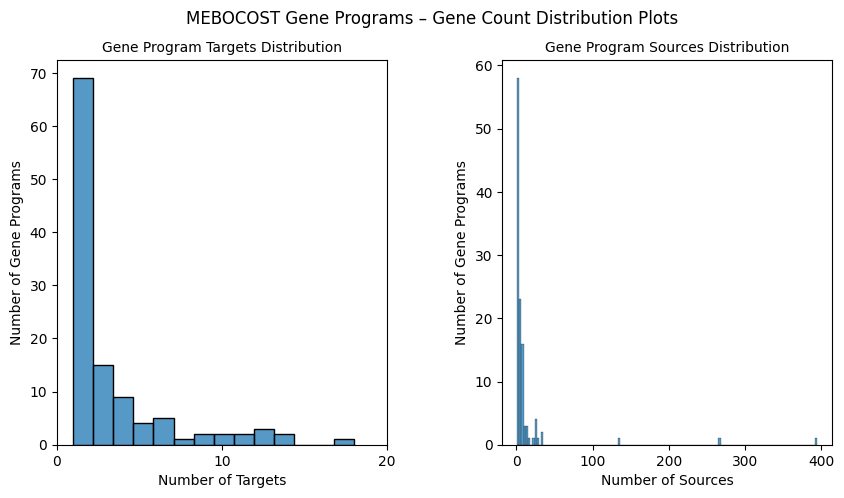

In [12]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_ms_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=True)

In [13]:
mebocost_gp_names = list(mebocost_gp_dict.keys())
random.shuffle(mebocost_gp_names)
mebocost_gp_name = mebocost_gp_names[0]
print(f"{mebocost_gp_name}: {mebocost_gp_dict[mebocost_gp_name]}")

Glycerol_metabolite_enzyme_sensor_GP: {'sources': ['Abhd12', 'Abhd6', 'Crls1', 'Enpp6', 'Gdpd2', 'Gla', 'Lipe', 'Mgll'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme'], 'targets': ['Aqp3'], 'targets_categories': ['sensor']}


In [14]:
adata=sc.read_h5ad('/home/dbj/SpaLP/Tutorialdata/CosMxMouseBrain.h5ad')
adata.var_names_make_unique()
adata.obs['truth']=adata.obs['spatialClusteringAssignments']
adata.obs['truth'] = adata.obs['truth'].astype('category')
adata

AnnData object with n_obs × n_vars = 48180 × 950
    obs: 'spatialClusteringAssignments', 'truth'
    uns: 'RNA_nbclust_clusters_colors', 'spatialClusteringAssignments_colors'
    obsm: 'spatial'

In [15]:
import time
from memory_profiler import memory_usage
import torch
device_idx=0
def measure_resources(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        mem_usage = memory_usage((func, args, kwargs), max_usage=True) / 1024
        end_time = time.time()
        execution_time = end_time - start_time
        minutes = execution_time // 60
        seconds = execution_time % 60
        if torch.cuda.is_available():
            device = torch.device(f"cuda:{device_idx}")
            allocated = torch.cuda.memory_allocated(device) / (1024 ** 3) 
            cached = torch.cuda.memory_reserved(device) / (1024 ** 3)
        else:
            allocated = cached = 0

        print(f"Function '{func.__name__}' executed in {minutes} minutes and {seconds:.4f} seconds.")
        print(f"Memory usage: {mem_usage:.2f} GB")
        print(f"GPU memory allocated: {allocated:.2f} GB")
        print(f"GPU memory cached: {cached:.2f} GB")

    return wrapper

In [16]:
@measure_resources
def run_pipeline(adata):
    gp_dicts = [omnipath_gp_dict, nichenet_gp_dict, mebocost_gp_dict]
    combined_gp_dict = filter_and_combine_gp_dict_gps_v2(gp_dicts,verbose=False)
    
    print(f"Number of gene programs after filtering and combining: "
          f"{len(combined_gp_dict)}.")
    sq.gr.spatial_neighbors(adata,coord_type="generic",spatial_key=spatial_key,n_neighs=n_neighbors)
    
    # Make adjacency matrix symmetric
    adata.obsp[adj_key] = (adata.obsp[adj_key].maximum(adata.obsp[adj_key].T))
    
    add_gps_from_gp_dict_to_adata(
        gp_dict=combined_gp_dict,
        adata=adata,
        gp_targets_mask_key=gp_targets_mask_key,
        gp_targets_categories_mask_key=gp_targets_categories_mask_key,
        gp_sources_mask_key=gp_sources_mask_key,
        gp_sources_categories_mask_key=gp_sources_categories_mask_key,
        gp_names_key=gp_names_key,
        min_genes_per_gp=2,
        min_source_genes_per_gp=1,
        min_target_genes_per_gp=1,
        max_genes_per_gp=None,
        max_source_genes_per_gp=None,
        max_target_genes_per_gp=None)
    
    from scipy.sparse import issparse, csr_matrix
    X = adata.X.copy()
    if not issparse(X):
        X_csr = csr_matrix(X)
    else:
        X_csr = X.tocsr()
    adata.X = X_csr
    adata.layers["counts"] = X_csr
    
    model = NicheCompass(adata,
                         counts_key=counts_key,
                         adj_key=adj_key,
                         gp_names_key=gp_names_key,
                         active_gp_names_key=active_gp_names_key,
                         gp_targets_mask_key=gp_targets_mask_key,
                         gp_targets_categories_mask_key=gp_targets_categories_mask_key,
                         gp_sources_mask_key=gp_sources_mask_key,
                         gp_sources_categories_mask_key=gp_sources_categories_mask_key,
                         latent_key=latent_key,
                         conv_layer_encoder=conv_layer_encoder,
                         active_gp_thresh_ratio=active_gp_thresh_ratio)
    
    model.train(n_epochs=n_epochs,
                n_epochs_all_gps=n_epochs_all_gps,
                lr=lr,
                lambda_edge_recon=lambda_edge_recon,
                lambda_gene_expr_recon=lambda_gene_expr_recon,
                lambda_l1_masked=lambda_l1_masked,
                edge_batch_size=100000,
                n_sampled_neighbors=n_sampled_neighbors,
                use_cuda_if_available=use_cuda_if_available,
                verbose=False)

In [17]:
run_pipeline(adata)

Number of gene programs after filtering and combining: 1582.
--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 950, n_cat_covariates_embed_input: 0, n_hidden: 270, n_latent: 170, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 170, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 950
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 170, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 950

--- INITIALIZING TRAINER ---
Number of training nodes: 43362
Number of validation nodes: 4818
Number of training edges: 245647
Number 

In [18]:
@measure_resources
def run_leiden(adata):
    sc.pp.neighbors(adata, use_rep='nichecompass_latent')
    sc.tl.leiden(adata, random_state=2024, resolution=0.46,key_added='NicheCompass_leiden')
run_leiden(adata=adata)

Function 'run_leiden' executed in 0.0 minutes and 59.2164 seconds.
Memory usage: 4.79 GB
GPU memory allocated: 0.02 GB
GPU memory cached: 8.04 GB


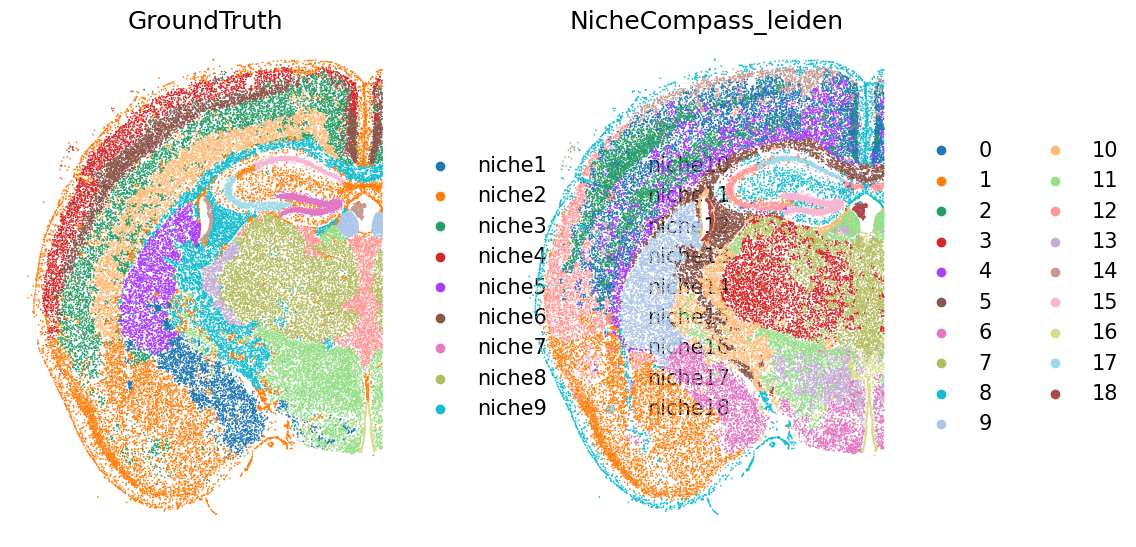

In [19]:
import matplotlib.pyplot as plt
import copy
from scanpy.plotting import palettes
plt.rcParams['figure.figsize'] = (5,6.5)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata, basis="spatial",s=6, color=['spatialClusteringAssignments','NicheCompass_leiden'],colorbar_loc=None,title='GroundTruth',frameon=False,palette=palettes.default_20)

In [25]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['spatialClusteringAssignments'])
cluster_labels = np.array(adata.obs['NicheCompass_leiden'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.3979474122570201
NMI: 0.6235857690291146
AMI: 0.6231364374674908
FMI: 0.45128539702299536
V-Measure: 0.6235857690291146
Homogeneity: 0.654028487223073


In [26]:
from sklearn.cluster import KMeans
@measure_resources
def run_kmeans(adata):
    kmeans = KMeans(n_clusters=19, random_state=2024) 
    labels = kmeans.fit_predict(adata.obsm['nichecompass_latent'])
    adata.obs['NicheCompass_kmeans']=labels.astype(str)
run_kmeans(adata=adata)

Function 'run_kmeans' executed in 0.0 minutes and 0.6847 seconds.
Memory usage: 4.08 GB
GPU memory allocated: 0.02 GB
GPU memory cached: 8.04 GB


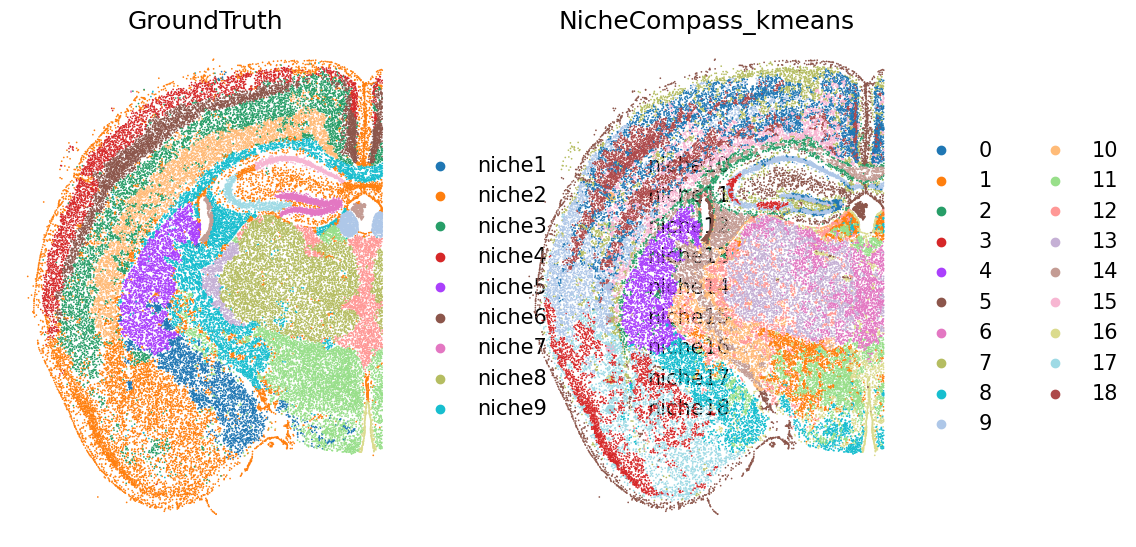

In [27]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,6.5)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata, basis="spatial",s=6, color=['spatialClusteringAssignments','NicheCompass_kmeans'],colorbar_loc=None,title='GroundTruth',frameon=False,palette=palettes.default_20)

In [28]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['spatialClusteringAssignments'])
cluster_labels = np.array(adata.obs['NicheCompass_kmeans'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.30275280312565095
NMI: 0.5493779540226874
AMI: 0.5488503220622756
FMI: 0.36251625197610016
V-Measure: 0.5493779540226874
Homogeneity: 0.585622709381218


In [29]:
adata.write_h5ad('/home/dbj/STAGATE/NicheCompass_CosMx_mousebrain_k_10.h5ad',compression='gzip')